<a href="https://colab.research.google.com/github/kamnaraikwal/Driver-Drowsiness-Detection-System/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# os -> for interacting with file system
# cv2 -> for image processing
# to_categorical ->  to convert class labels into one-hot encoded format
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import pickle

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
# path = '/content/drive/My Drive/DeepLearning'

100%|██████████| 2.58G/2.58G [02:14<00:00, 20.6MB/s]

Extracting files...


In [ ]:
class_labels = {'Drowsy': 0, 'Non Drowsy': 1}
SAMPLE_PERCENTAGE = 0.1
path = os.path.join(path, 'Driver Drowsiness Dataset (DDD)')
all_image_paths = []
all_labels = []
BATCH_SIZE= 32

In [ ]:
# for custom model and vgg16 and fnn -> 227
# for googleNet -> 299
# for resNet and denseNet -> 224
IMG_SIZE = 227

In [ ]:
for folder_name, label in class_labels.items():
    folder_path = os.path.join(path, folder_name)
    image_files = os.listdir(folder_path)
    print(f"{folder_name}: Found {len(image_files)} images")

    sample_size = int(len(image_files) * SAMPLE_PERCENTAGE)
    sampled_files = random.sample(image_files, sample_size)

    for img_file in sampled_files:
        img_path = os.path.join(folder_path, img_file)
        all_image_paths.append(img_path)
        all_labels.append(label)


Drowsy: Found 22348 images
Non Drowsy: Found 19445 images


In [ ]:
# preprocessing using GPU
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, tf.one_hot(label, depth=2)


In [ ]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 225, 225, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7788 - loss: 0.7707 - val_accuracy: 0.9804 - val_loss: 0.0840
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9692 - loss: 0.0989 - val_accuracy: 0.9929 - val_loss: 0.0350
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9809 - loss: 0.0530 - val_accuracy: 0.9911 - val_loss: 0.0221
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9872 - loss: 0.0345 - val_accuracy: 0.9929 - val_loss: 0.0236
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9889 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 3.6346e-04
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9940 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 8.1888e-04
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9976 - loss: 0.0135 - va

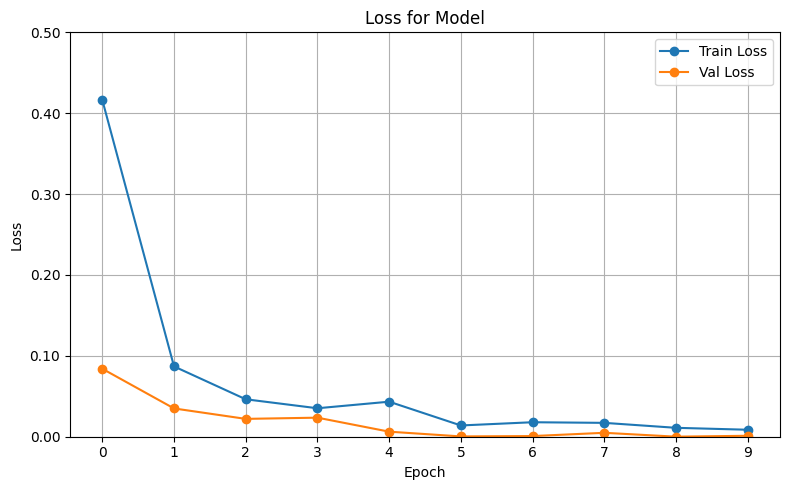

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization

In [ ]:
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(227, 227, 3))

# Transfer Laerning- freeze all
for layer in base_model_vgg.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)


In [ ]:
model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 227, 227, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 227, 227, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 113, 113, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 113, 113, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_vgg = model_vgg.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=6
)


Epoch 1/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 65s 707ms/step - accuracy: 0.8073 - loss: 0.4705 - val_accuracy: 0.9964 - val_loss: 0.0606
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.9895 - loss: 0.0585 - val_accuracy: 0.9982 - val_loss: 0.0194
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.9994 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.9995 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.9995 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0030


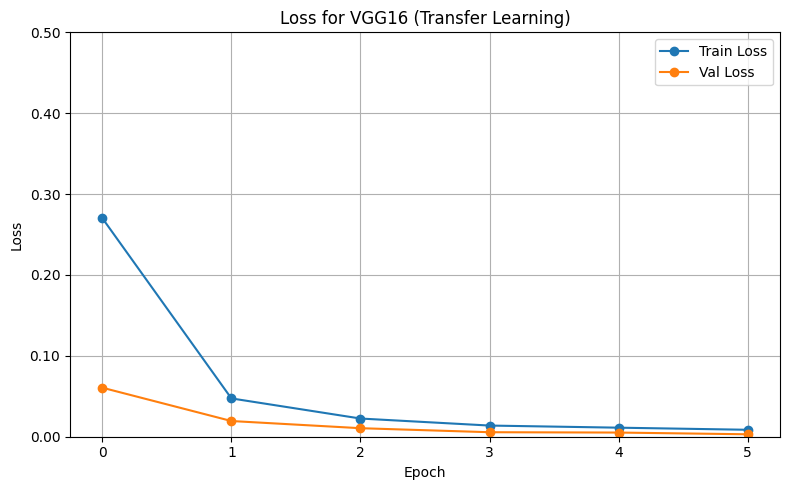

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_vgg.history['loss'], label='Train Loss', marker='o')
plt.plot(history_vgg.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_vgg.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for VGG16 (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# fine tuning in continuation
for layer in base_model_vgg.layers[-4:]:
    layer.trainable = True

model_vgg.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_ft = model_vgg.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 362ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 4.9208e-04
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - accuracy: 1.0000 - loss: 4.2904e-04 - val_accuracy: 1.0000 - val_loss: 9.8221e-05
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.7705e-04
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 1.0000 - loss: 4.0909e-04 - val_accuracy: 1.0000 - val_loss: 6.6356e-05
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 1.0000 - loss: 1.4733e-04 - val_accuracy: 1.0000 - val_loss: 3.7739e-05


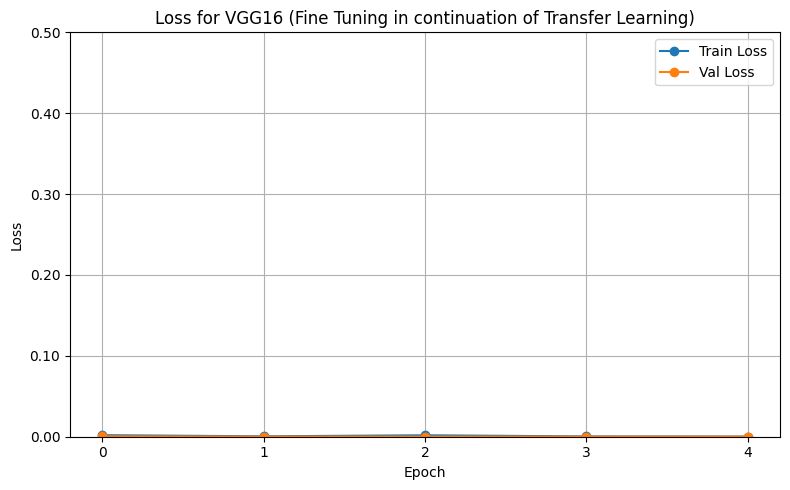

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_ft.history['loss'], label='Train Loss', marker='o')
plt.plot(history_ft.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_ft.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for VGG16 (Fine Tuning in continuation of Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_vgg.save('driver_drowsiness_vgg16.h5')

In [ ]:
from google.colab import files
files.download('driver_drowsiness_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.metrics import classification_report


In [ ]:
# to numpy for OpenCV
data, labels=[], []

for batch_images, batch_labels in train_dataset.concatenate(test_dataset):
    data.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())


In [ ]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, len(data),  labels.shape)

(2798, 227, 227, 3) 2798 (2798, 2)


In [ ]:
def extract_hog_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    return features


In [ ]:
def extract_sift_features(img, max_features=100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros((max_features * 128,))

    if descriptors.shape[0] > max_features:
        descriptors = descriptors[:max_features]
    else:
        pad = np.zeros((max_features - descriptors.shape[0], 128))
        descriptors = np.vstack((descriptors, pad))
    return descriptors.flatten()

In [ ]:
X_hog, X_sift, X_combined = [], [], []

for img in data:
    img_uint8 = cv2.convertScaleAbs(img)  # Ensure valid type for OpenCV

    hog_feat = extract_hog_features(img_uint8)
    sift_feat = extract_sift_features(img_uint8)
    combined = np.concatenate((hog_feat, sift_feat))

    X_hog.append(hog_feat)
    X_sift.append(sift_feat)
    X_combined.append(combined)

X_hog = np.array(X_hog)
X_sift = np.array(X_sift)
X_combined = np.array(X_combined)

print("Shapes:", X_hog.shape, X_sift.shape, X_combined.shape)


Shapes: (2798, 26244) (2798, 12800) (2798, 39044)


In [ ]:
def create_fnn(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
scaler_hog = StandardScaler().fit(X_hog)
X_hog = scaler_hog.transform(X_hog)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_hog, labels, test_size=0.2, stratify=labels)


In [ ]:
model_hog = create_fnn(X_hog.shape[1])
history_hog = model_hog.fit(Xh_train, yh_train, validation_data=(Xh_test, yh_test), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8967 - loss: 0.3034 - val_accuracy: 0.9946 - val_loss: 0.0205
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9945 - loss: 0.0249 - val_accuracy: 0.9964 - val_loss: 0.0451
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9951 - loss: 0.0537 - val_accuracy: 1.0000 - val_loss: 3.3758e-04
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9929 - val_loss: 0.0301
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 4.0647e-04
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9942 - loss: 0.0276 - val_accuracy: 0.9893 - val_loss: 0.0344
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 5.7275e-06
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0063 - val_accuracy: 1.000

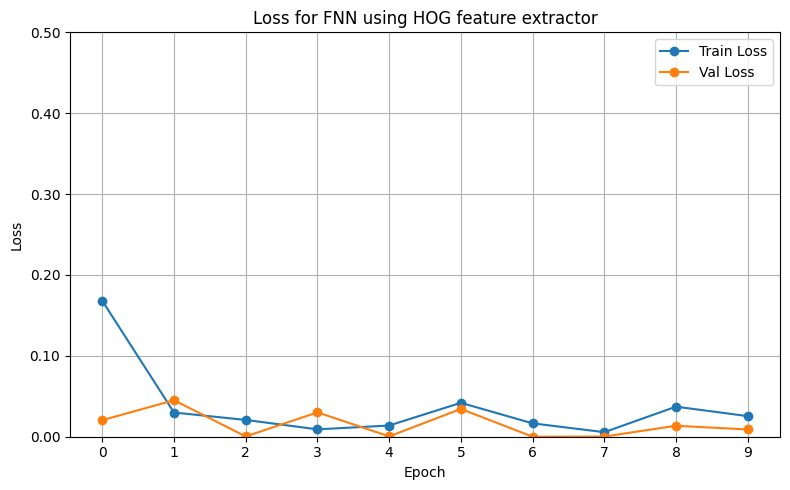

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_hog.history['loss'], label='Train Loss', marker='o')
plt.plot(history_hog.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_hog.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for FNN using HOG feature extractor')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
scaler_sift = StandardScaler().fit(X_sift)
X_sift = scaler_sift.transform(X_sift)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_sift, labels, test_size=0.2, stratify=labels)


In [ ]:
# change
model_sift = create_fnn(X_sift.shape[1])
history_sift = model_sift.fit(Xs_train, ys_train, validation_data=(Xs_test, ys_test), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7792 - loss: 0.6832 - val_accuracy: 0.7982 - val_loss: 0.6543
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8038 - loss: 0.6451 - val_accuracy: 0.7982 - val_loss: 0.6232
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7997 - loss: 0.6162 - val_accuracy: 0.7982 - val_loss: 0.5977
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8079 - loss: 0.5884 - val_accuracy: 0.7982 - val_loss: 0.5768
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7892 - loss: 0.5772 - val_accuracy: 0.7982 - val_loss: 0.5603
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7944 - loss: 0.5591 - val_accuracy: 0.7982 - val_loss: 0.5470
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7906 - loss: 0.5494 - val_accuracy: 0.7982 - val_loss: 0.5365
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8146 - loss: 0.5216 - val_accuracy: 0.7982 - val_loss

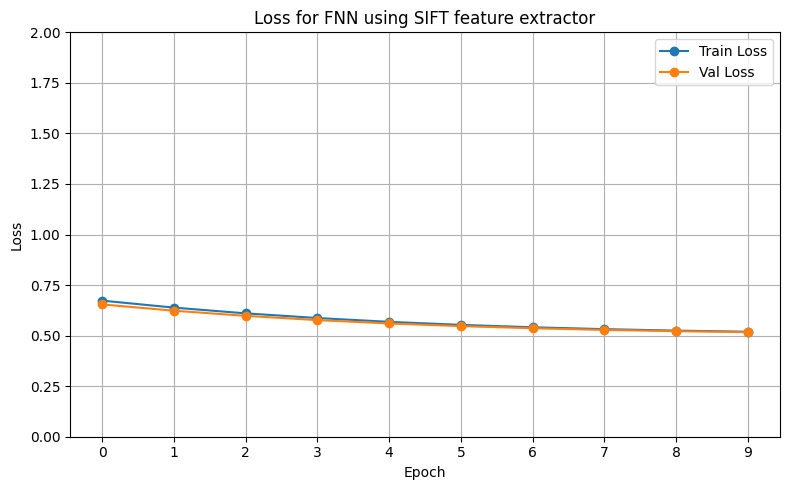

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_sift.history['loss'], label='Train Loss', marker='o')
plt.plot(history_sift.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 2.0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_sift.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for FNN using SIFT feature extractor')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
scaler_comb = StandardScaler().fit(X_combined)
X_combined = scaler_comb.transform(X_combined)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_combined, labels, test_size=0.2, stratify=labels)


In [ ]:
model_comb = create_fnn(X_combined.shape[1])
history_comb = model_comb.fit(Xc_train, yc_train, validation_data=(Xc_test, yc_test), epochs=10, batch_size=32)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8816 - loss: 0.4168 - val_accuracy: 0.9946 - val_loss: 0.0262
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9958 - loss: 0.0155 - val_accuracy: 0.9875 - val_loss: 0.0620
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9963 - loss: 0.0087 - val_accuracy: 0.9946 - val_loss: 0.0428
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9917 - loss: 0.0546 - val_accuracy: 0.9929 - val_loss: 0.0401
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9962 - loss: 0.0418 - val_accuracy: 0.9929 - val_loss: 0.0515
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9928 - loss: 0.0755 - val_accuracy: 0.9911 - val_loss: 0.1093
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9964 - val_loss: 0.0414
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9973 - loss: 0.0135 - val_accuracy: 0.9946 - val_l

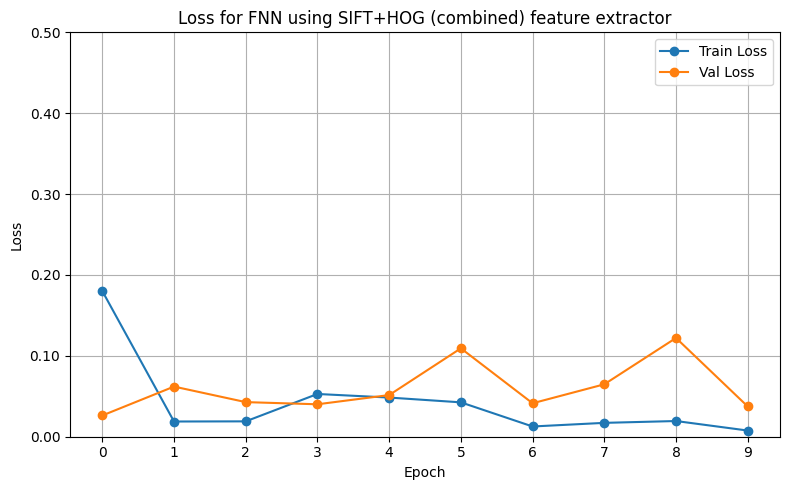

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_comb.history['loss'], label='Train Loss', marker='o')
plt.plot(history_comb.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_comb.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for FNN using SIFT+HOG (combined) feature extractor')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {name}")
    print(classification_report(y_true, y_pred_labels, target_names=['Drowsy', 'Non Drowsy']))

evaluate_model(model_hog, Xh_test, yh_test, "FNN-HOG")
evaluate_model(model_sift, Xs_test, ys_test, "FNN-SIFT")
evaluate_model(model_comb, Xc_test, yc_test, "FNN-HOG+SIFT")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report for FNN-HOG+SIFT
              precision    recall  f1-score   support

      Drowsy       0.99      1.00      0.99       447
  Non Drowsy       1.00      0.98      0.99       389

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models, optimizers

In [ ]:
base_model_gNet = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model_gNet.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs)  # InceptionV3 preprocessing
x = base_model_gNet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Change to 1 + sigmoid for binary classification
model_gNet = models.Model(inputs, outputs)

In [ ]:
model_gNet.compile(optimizer='adam',
              loss='categorical_crossentropy',  # binary_crossentropy for binary class
              metrics=['accuracy'])

In [ ]:
history_gNet = model_gNet.fit(train_dataset, epochs=5, validation_data=test_dataset)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7545 - loss: 0.5424 - val_accuracy: 0.7982 - val_loss: 0.4698
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.8163 - loss: 0.4650 - val_accuracy: 0.7982 - val_loss: 0.4474
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.8190 - loss: 0.4374 - val_accuracy: 0.8000 - val_loss: 0.4271
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.8280 - loss: 0.4182 - val_accuracy: 0.8045 - val_loss: 0.4087
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.8334 - loss: 0.4015 - val_accuracy: 0.8259 - val_loss: 0.3931


In [ ]:
base_model_gNet.trainable = True
fine_tune_at = 249

for layer in base_model_gNet.layers[:fine_tune_at]:
    layer.trainable = False

model_gNet.compile(optimizer=optimizers.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs

history_fine = model_gNet.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history_gNet.epoch[-1],  # resume from previous phase
    validation_data=test_dataset
)


Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 354ms/step - accuracy: 0.8162 - loss: 2.6603 - val_accuracy: 0.8241 - val_loss: 0.4663
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.8968 - loss: 0.4511 - val_accuracy: 0.9643 - val_loss: 0.1273
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.9656 - loss: 0.1162 - val_accuracy: 0.9929 - val_loss: 0.0367
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.9784 - loss: 0.0645 - val_accuracy: 0.9964 - val_loss: 0.0153
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.9870 - loss: 0.0444 - val_accuracy: 0.9973 - val_loss: 0.0092
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.9927 - loss: 0.0258 - val_accuracy: 0.9982 - val_loss: 0.0065


In [ ]:
combined_history = {}
for key in history_gNet.history.keys():
    combined_history[key] = history_gNet.history[key] + history_fine.history[key]

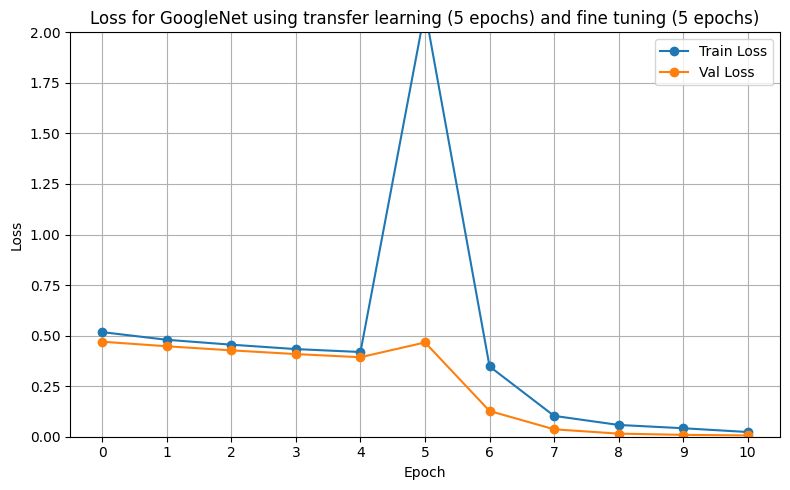

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(combined_history['loss'], label='Train Loss', marker='o')
plt.plot(combined_history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 2.0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(combined_history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for GoogleNet using transfer learning (5 epochs) and fine tuning (5 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras import layers, models, optimizers

In [ ]:
base_model_resNet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model_resNet.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model_resNet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_resNet = models.Model(inputs, outputs)

model_resNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_resNet.fit(train_dataset, epochs=4, validation_data=test_dataset)


Epoch 1/4
105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 323ms/step - accuracy: 0.4962 - loss: 0.8001 - val_accuracy: 0.5598 - val_loss: 0.6740
Epoch 2/4
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.5509 - loss: 0.6893 - val_accuracy: 0.6100 - val_loss: 0.6536
Epoch 3/4
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.5753 - loss: 0.6699 - val_accuracy: 0.6507 - val_loss: 0.6429
Epoch 4/4
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.6128 - loss: 0.6530 - val_accuracy: 0.6687 - val_loss: 0.6315


In [ ]:
base_model_resNet.trainable = True
for layer in base_model_resNet.layers[:-20]:
    layer.trainable = False

model_resNet.compile(
    optimizer=optimizers.Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 4
total_epochs = 4 + fine_tune_epochs

history_fine = model_resNet.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset
)

Epoch 4/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - accuracy: 0.4823 - loss: 2.4044 - val_accuracy: 0.5395 - val_loss: 0.6864
Epoch 5/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7187 - loss: 0.6196 - val_accuracy: 0.5347 - val_loss: 0.8927
Epoch 6/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8363 - loss: 0.4165 - val_accuracy: 0.5789 - val_loss: 0.6518
Epoch 7/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8801 - loss: 0.3283 - val_accuracy: 0.7691 - val_loss: 0.5177
Epoch 8/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9157 - loss: 0.2656 - val_accuracy: 0.9246 - val_loss: 0.3084


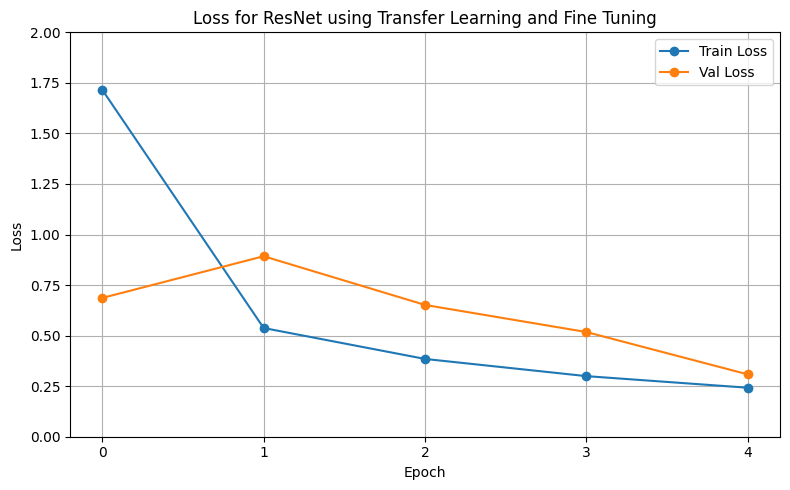

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o')
plt.plot(history_fine.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 2.0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history_fine.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for ResNet using Transfer Learning and Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras import layers, models, optimizers

In [ ]:
base_model_denseNet = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model_denseNet.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model_denseNet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_denseNet = models.Model(inputs, outputs)

model_denseNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_denseNet.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 441ms/step - accuracy: 0.5145 - loss: 0.8281 - val_accuracy: 0.7691 - val_loss: 0.5310
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6954 - loss: 0.5643 - val_accuracy: 0.8768 - val_loss: 0.4205
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7949 - loss: 0.4696 - val_accuracy: 0.9342 - val_loss: 0.3561
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8175 - loss: 0.4211 - val_accuracy: 0.9438 - val_loss: 0.3124
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8651 - loss: 0.3722 - val_accuracy: 0.9522 - val_loss: 0.2823
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8670 - loss: 0.3536 - val_accuracy: 0.9653 - val_loss: 0.2541
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.8848 - loss: 0.3238 - val_accuracy: 0.9701 - val_loss: 0.2350
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8790 - loss: 0.

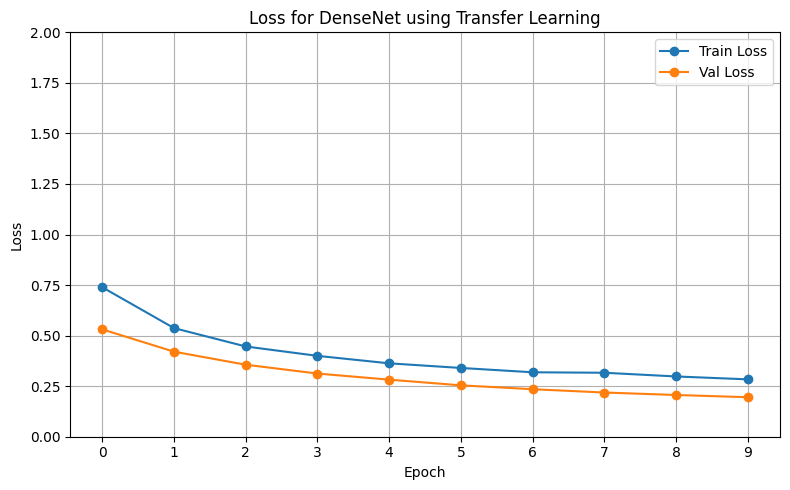

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')

plt.ylim(0.0, 2.0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

epochs = len(history.history['loss'])
plt.xticks(range(epochs))

plt.title('Loss for DenseNet using Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()